In [23]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [24]:
import pandas as pd
import pickle
import torch
import torch.nn as nn
import numpy as np
import tensorflow as tf
from keras.layers import Dense
from keras.models import Model
import matplotlib.pyplot as plt

Labels - happy, sad, neutral, angry, excited, and frustrate

- Train Test Splits INFO

  - trainVid (DICT dialogueId -> UtteranceID List): all dialogue IDs for trainset (total: 120)
  - testVid (LIST UtteranceID Set): all dialogue IDs for testset (total: 31)
  - videoIDs (LIST UtteranceID Set): all dialogue IDs for whole dataset (total: 120 + 31)

- Datasets Content (Dict DialogueId -> corresponding Features)

  - videoSpeakers : There are multiple participators in one dialogue. videoSpeakers maps utterance to its speakers
  - videoLabels : The emotion Labels for each utterance in a dialogue.
  - videoText : The text features extracts using TextCNN.
  - videoAudio : The video features extracts using openSMILE kitools
  - videoVisual : The visual features extracts using 3d-CNN.
  - videoSentence : The raw text info in a dialogue.

In [25]:
# Load the .pkl file
with open('/content/drive/MyDrive/MSA/IEMOCAP_features.pkl', 'rb') as file:
    dataset = pickle.load(file)

videoIDs, videoSpeakers, videoLabels, videoText, videoAudio, videoVisual, videoSentence, trainVid, testVid = dataset

In [26]:
print(f"videoIDs     : {len(videoIDs)}, {type(videoIDs)}")
print(f"videoSpeakers: {len(videoSpeakers)}, {type(videoSpeakers)}")
print(f"videoLabels  : {len(videoLabels)}, {type(videoLabels)}")
print(f"videoText    : {len(videoText)}, {type(videoText)}")
print(f"videoAudio   : {len(videoAudio)}, {type(videoAudio)}")
print(f"videoVisual  : {len(videoVisual)}, {type(videoVisual)}")
print(f"videoSentence: {len(videoSentence)}, {type(videoSentence)}")
print(f"\nVideos in Training Dataset: {len(trainVid)}\t{type(trainVid)}")
print(f"Videos in Testing Dataset : {len(testVid)}\t{type(testVid)}")

videoIDs     : 151, <class 'dict'>
videoSpeakers: 151, <class 'dict'>
videoLabels  : 151, <class 'dict'>
videoText    : 151, <class 'dict'>
videoAudio   : 151, <class 'dict'>
videoVisual  : 151, <class 'dict'>
videoSentence: 151, <class 'dict'>

Videos in Training Dataset: 120	<class 'list'>
Videos in Testing Dataset : 31	<class 'list'>


In [27]:
# To get an idea regarding Dataset
video = 0
print(f"For Video {trainVid[video]} there are {len(videoIDs[trainVid[video]])} Clips")
print(f"Clip IDs of Video are\n{videoIDs[trainVid[video]]}")

# clip = 0
# print(f"\nFor Clip {videoIDs[video][clip]}")
# print(f"Speaker  : {videoSpeakers[trainVid[video]][clip]}")
# print(f"Label    : {videoLabels[trainVid[video]][clip]}")
# print(f"Sentence : {videoSentence[trainVid[video]][clip]}")
# print(f"Text     : {videoText[trainVid[video]][clip]}")
# print(f"Audio    : {videoAudio[trainVid[video]][clip]}")
# print(f"Visual   : {videoVisual[trainVid[video]][clip]}")

For Video Ses02F_script01_3 there are 30 Clips
Clip IDs of Video are
['Ses02F_script01_3_M001', 'Ses02F_script01_3_F009', 'Ses02F_script01_3_M010', 'Ses02F_script01_3_F012', 'Ses02F_script01_3_F013', 'Ses02F_script01_3_F014', 'Ses02F_script01_3_F016', 'Ses02F_script01_3_M020', 'Ses02F_script01_3_F020', 'Ses02F_script01_3_M021', 'Ses02F_script01_3_F021', 'Ses02F_script01_3_M022', 'Ses02F_script01_3_F022', 'Ses02F_script01_3_M023', 'Ses02F_script01_3_F023', 'Ses02F_script01_3_M024', 'Ses02F_script01_3_F024', 'Ses02F_script01_3_M025', 'Ses02F_script01_3_F025', 'Ses02F_script01_3_M026', 'Ses02F_script01_3_M027', 'Ses02F_script01_3_M028', 'Ses02F_script01_3_M029', 'Ses02F_script01_3_M030', 'Ses02F_script01_3_M031', 'Ses02F_script01_3_M032', 'Ses02F_script01_3_M033', 'Ses02F_script01_3_M034', 'Ses02F_script01_3_F026', 'Ses02F_script01_3_F029']


In [28]:
video,clip = 0,0
print(f"Features in a Clip's Text Feature: {len(videoText[trainVid[video]][clip])}")
# print(f"Text Feature of Clip '{videoIDs[trainVid[video]][clip]}'\n{videoText[trainVid[video]][clip]}")

Features in a Clip's Text Feature: 100


In [29]:
# Define a simple Bi-GRU for text data
class TextBiGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_directions):
        super(TextBiGRU, self).__init__()
        self.hidden_size = hidden_size  # Size of the hidden state in the GRU
        self.num_layers = num_layers  # Number of stacked GRU layers
        self.num_directions = num_directions  # Number of directions, 2 for a bidirectional GRU
        # Define the GRU layer, set batch_first=True for input/output tensors to have shape (batch_size, seq_length, feature)
        self.bigru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)

    def forward(self, x):
        # Initial hidden state of zeros
        h0 = torch.zeros(self.num_layers * self.num_directions, x.size(0), self.hidden_size).to(x.device)
        # Forward propagate the GRU and get the output (out) and hidden state (hn)
        out, _ = self.bigru(x, h0)
        return out

# Hyperparameters
input_size = len(videoText[trainVid[0]][0])  # Input size (dimension of video-text vector)
hidden_size = 128  # Hidden state dimension
num_layers = 2  # Number of layers
num_directions = 2  # Bidirectional GRU
batch_size = len(trainVid)

# Initialize the BiGRU model
bi_gru_model_text = TextBiGRU(input_size, hidden_size, num_layers, num_directions)

# Convert Clip list to a sequence of tensors
clip_list = [torch.tensor(np.array(videoText[i])) for i in trainVid]

# Pad the sequences to have the same length
input_text = nn.utils.rnn.pad_sequence(clip_list, batch_first=True)
print(f"Input Shape : {input_text.shape}")

# Process the data
output_text = bi_gru_model_text(input_text)
print(f"Output Shape : {output_text.shape}")

Input Shape : torch.Size([120, 110, 100])
Output Shape : torch.Size([120, 110, 256])


In [30]:
video,clip = 0,0
print(f"Features in a Clip's Audio Feature: {len(videoAudio[trainVid[video]][clip])}")
# print(f"Audio Feature of Clip '{videoIDs[trainVid[video]][clip]}'\n{videoAudio[trainVid[video]][clip]}")

Features in a Clip's Audio Feature: 100


In [31]:
# Define a simple Bi-GRU for audio data
class AudioBiGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_directions):
        super(AudioBiGRU, self).__init__()
        self.hidden_size = hidden_size  # Size of the hidden state in the GRU
        self.num_layers = num_layers  # Number of stacked GRU layers
        self.num_directions = num_directions  # Number of directions, 2 for a bidirectional GRU
        # Define the GRU layer, set batch_first=True for input/output tensors to have shape (batch_size, seq_length, feature)
        self.bigru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)

    def forward(self, x):
        # Initial hidden state of zeros
        h0 = torch.zeros(self.num_layers * self.num_directions, x.size(0), self.hidden_size).to(x.device)
        # Forward propagate the GRU and get the output (out) and hidden state (hn)
        out, _ = self.bigru(x, h0)
        return out

# Hyperparameters
input_size = len(videoAudio[trainVid[0]][0])  # Input size (dimension of video-text vector)
hidden_size = 128  # Hidden state dimension
num_layers = 2  # Number of layers
num_directions = 2  # Bidirectional GRU
batch_size = len(trainVid)

# Initialize the BiGRU model
bi_gru_model_audio = AudioBiGRU(input_size, hidden_size, num_layers, num_directions)

# Convert the dictionary of lists to a sequence of tensors
clip_list = [torch.tensor(np.array(videoAudio[i])) for i in trainVid]

# Pad the sequences to have the same length
input_audio = nn.utils.rnn.pad_sequence(clip_list, batch_first=True)
print(f"Input Shape : {input_audio.shape}")

# Process the data
output_audio = bi_gru_model_audio(input_audio)
print(f"Output Shape : {output_audio.shape}")

Input Shape : torch.Size([120, 110, 100])
Output Shape : torch.Size([120, 110, 256])


In [32]:
video,clip = 0,0
print(f"Features in a Clip's Visual Feature: {len(videoVisual[trainVid[video]][clip])}")
# print(f"Visual Feature of Clip '{videoIDs[trainVid[video]][clip]}'\n{videoVisual[trainVid[video]][clip]}")

Features in a Clip's Visual Feature: 512


In [33]:
# Define a simple Bi-GRU for visual data
class VisualBiGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_directions):
        super(VisualBiGRU, self).__init__()
        self.hidden_size = hidden_size  # Size of the hidden state in the GRU
        self.num_layers = num_layers  # Number of stacked GRU layers
        self.num_directions = num_directions  # Number of directions, 2 for a bidirectional GRU
        # Define the GRU layer, set batch_first=True for input/output tensors to have shape (batch_size, seq_length, feature)
        self.bigru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)

    def forward(self, x):
        # Initial hidden state of zeros
        h0 = torch.zeros(self.num_layers * self.num_directions, x.size(0), self.hidden_size).to(x.device)
        # Forward propagate the GRU and get the output (out) and hidden state (hn)
        out, _ = self.bigru(x, h0)
        return out

# Hyperparameters
input_size = len(videoVisual[trainVid[0]][0])  # Input size (dimension of video-text vector)
hidden_size = 128  # Hidden state dimension
num_layers = 2  # Number of layers
num_directions = 2  # Bidirectional GRU
batch_size = len(trainVid)

# Initialize the BiGRU model
bi_gru_model_visual = VisualBiGRU(input_size, hidden_size, num_layers, num_directions)

# Convert the dictionary of lists to a sequence of tensors
clip_list = [torch.tensor(np.array(videoVisual[i])) for i in trainVid]

# Pad the sequences to have the same length
input_visual = nn.utils.rnn.pad_sequence(clip_list, batch_first=True)
print(f"Input Shape : {input_visual.shape}")

# Process the data
output_visual = bi_gru_model_visual(input_visual)
print(f"Output Shape : {output_visual.shape}")

Input Shape : torch.Size([120, 110, 512])
Output Shape : torch.Size([120, 110, 256])


In [34]:
# Combine Features
# Here we implement simple concatenation instead of Dense Fusion Module & Multimodal Residual Module
combined_features = tf.concat([output_text.detach().numpy(), output_audio.detach().numpy(), output_visual.detach().numpy()], axis=-1)

# Output Layer
# Sentiment Classification Module
num_classes = 6
train_input = Dense(num_classes, activation='softmax')(combined_features)
train_input.shape

TensorShape([120, 110, 6])

In [35]:
# Labels
video,clip = 0,0
print(f"Label of Clip '{videoIDs[trainVid[video]][clip]}': {videoLabels[trainVid[video]][clip]}")

Label of Clip 'Ses02F_script01_3_M001': 2


In [36]:
label_list = [np.array(videoLabels[i]) for i in trainVid]
label_rep = {
    0: [1, 0, 0, 0, 0, 0],
    1: [0, 1, 0, 0, 0, 0],
    2: [0, 0, 1, 0, 0, 0],
    3: [0, 0, 0, 1, 0, 0],
    4: [0, 0, 0, 0, 1, 0],
    5: [0, 0, 0, 0, 0, 1]
}

new_label_list = []
for i in range(len(label_list)):
  temp = []
  for j in range(len(label_list[i])):
    temp.append(label_rep[label_list[i][j]])
  new_label_list.append(temp)

label_list = [torch.tensor(i) for i in new_label_list]

# Pad the sequences to have the same length
train_labels = nn.utils.rnn.pad_sequence(label_list, batch_first=True)

print(f"Labels Shape : {train_labels.shape}")
# print(train_labels)

Labels Shape : torch.Size([120, 110, 6])


In [37]:
model = tf.keras.models.Sequential([
    Dense(6, input_shape=(None, None, train_input.shape[2]), use_bias=False)
])

train_input = tf.convert_to_tensor(train_input)
train_labels = tf.convert_to_tensor(train_labels)

# Compile your model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy', 'Precision', 'Recall', 'AUC'])
# 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'

In [38]:
bigru_input_text = [torch.tensor(np.array(videoText[i])) for i in testVid]
bigru_input_text = nn.utils.rnn.pad_sequence(bigru_input_text, batch_first=True)
bigru_output_text = bi_gru_model_text(bigru_input_text)

bigru_input_audio = [torch.tensor(np.array(videoAudio[i])) for i in testVid]
bigru_input_audio = nn.utils.rnn.pad_sequence(bigru_input_audio, batch_first=True)
bigru_output_audio = bi_gru_model_audio(bigru_input_audio)

bigru_input_visual = [torch.tensor(np.array(videoVisual[i])) for i in testVid]
bigru_input_visual = nn.utils.rnn.pad_sequence(bigru_input_visual, batch_first=True)
bigru_output_visual = bi_gru_model_visual(bigru_input_visual)

test_combined_features = tf.concat([bigru_output_text.detach().numpy(), bigru_output_audio.detach().numpy(), bigru_output_visual.detach().numpy()], axis=-1)
num_classes = 6
test_input = Dense(num_classes, activation='softmax')(test_combined_features)

test_labels = [np.array(videoLabels[i]) for i in testVid]
new_test_labels = []
for i in range(len(test_labels)):
  temp = []
  for j in range(len(test_labels[i])):
    temp.append(label_rep[test_labels[i][j]])
  new_test_labels.append(temp)
test_labels = [torch.tensor(i) for i in new_test_labels]
test_labels = nn.utils.rnn.pad_sequence(test_labels, batch_first=True)

print(test_input.shape)
print(test_labels.shape)

(31, 91, 6)
torch.Size([31, 91, 6])


In [39]:
model_history = model.fit(train_input.numpy(), train_labels.numpy(), epochs=1000, validation_data = (test_input.numpy(), test_labels.numpy()))

Epoch 1/1000
4/4 [==============================] - 1s 129ms/step - loss: 1.2191 - accuracy: 0.0843 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5099 - val_loss: 1.0718 - val_accuracy: 0.0252 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4899
Epoch 2/1000
4/4 [==============================] - 0s 23ms/step - loss: 1.1685 - accuracy: 0.0844 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5068 - val_loss: 1.0621 - val_accuracy: 0.0266 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4910
Epoch 3/1000
4/4 [==============================] - 0s 22ms/step - loss: 1.1227 - accuracy: 0.0844 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5052 - val_loss: 1.0429 - val_accuracy: 0.0291 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4921
Epoch 4/1000
4/4 [==============================] - 0s 23ms/step - loss: 1.0718 - accuracy: 0.0843 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5051 - val_loss: 1.0309 - val_acc

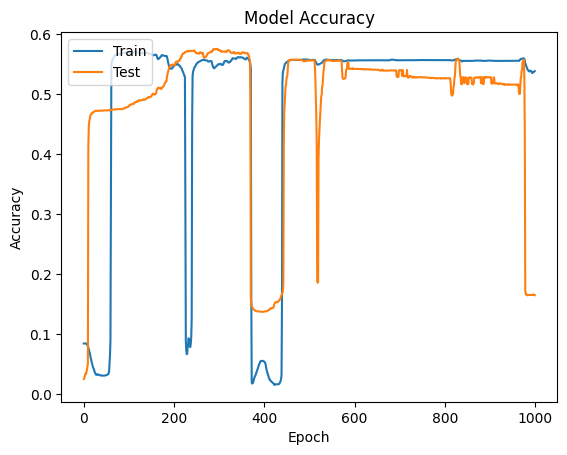

In [41]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

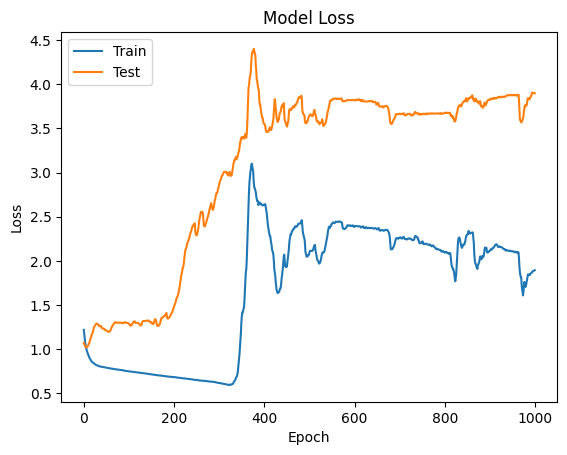

In [42]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, None, None, 6)     36        
                                                                 
Total params: 36 (144.00 Byte)
Trainable params: 36 (144.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
